<center>

*******************************************************************************************

### Phase-Locking Value

##### 12 March 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* "Phase-locking value" is a measure for synchrony of two or more periodic or recurrent signals. In this context, synchrony is defined as a stable phase difference, either in a short lapse of time, or across a number of trials or conditions.

>
* References:

    * Lachaux, J. P., Rodriguez, E., Martinerie, J., & Varela, F. J. (1999). Measuring phase synchrony in brain signals. *Human brain mapping, 8*(4), 194-208. https://doi.org/10.1002/(SICI)1097-0193(1999)8:4%3C194::AID-HBM4%3E3.0.CO;2-C

    *  Mormann, F., Lehnertz, K., David, P., & Elger, C. E. (2000). Mean phase coherence as a measure for phase synchronization and its application to the EEG of epilepsy patients. *Physica D: Nonlinear Phenomena, 144*(3-4), 358-369. https://doi.org/10.1016/S0167-2789(00)00087-7

    * Bruña, R., Maestú, F., & Pereda, E. (2018). Phase locking value revisited: teaching new tricks to an old dog. *Journal of neural engineering, 15*(5), 056011. https://doi.org/10.1088/1741-2552/aacfe4
>
* Instructions:

    Edit the values indicated with an arrow like this: <---\
    To test different methods, comment or uncomment the lines indicated with an arrow like this: <===\
    Run the program, close your eyes and hope for the best.

*******************************************************************************************

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
# sys.path.append(r"C:\Users\John_Price\SAS\SynCoord\src")
sys.path.append(r"C:\Users\juigmend\local_documents\SynCoord\src")
from syncoord import sc_ptdata, sc_ndarr, sc_utils

np.set_printoptions(suppress=True)

In [14]:
# from importlib import reload
# reload(sc_ptdata)
# reload(sc_ndarr);

***
### Generate synthetic data

In [15]:
def supersine(argdict):
    '''
    Produce a sine wave with optional variables for distortion.
    Arg:
            wavargs = dict()
        Required values:
            wavargs['frequency'] = f
            wavargs['phase_shift'] = ps
            wavargs['amplitude'] = a
            wavargs['sampling_frequency'] = sf
            wavargs['length'] = l
        Optional values:
            wavargs['vertical_offset'] = vo
            wavargs['irregularity'] = irr
            wavargs['noise_strength'] = ns
            wavargs['seed'] = s
    Returns:
        array
    '''
    from scipy.interpolate import CubicSpline

    f = argdict.get('frequency')
    ps = argdict.get('phase_shift')
    amp = argdict.get('amplitude')
    fps = argdict.get('sampling_frequency')
    l = argdict.get('length')
    v_offset = argdict.get('vertical_offset',0)
    irregularity = argdict.get('irregularity',0)
    noise_strength = argdict.get('noise_strength',0)
    noise_strength = noise_strength
    seed = argdict.get('seed',None)

    rangen = np.random.default_rng(seed=seed)
    t = np.arange(0, l)/fps
    y = np.sin(2*np.pi*f*t + ps/2)
    if irregularity:
        if irregularity >= 1:
            y = np.zeros(l)
        else:
            n_ran = int(np.ceil((l-2) * (1-irregularity)**2))
            if n_ran < 1: n_ran = 1
            ran_idx = np.sort(rangen.choice(np.arange(1,l), size=n_ran, replace=False))
            ip_x = np.insert(ran_idx, [0,n_ran], [0,l])
            ip_y = y[ran_idx]
            ip_y = ip_y - ip_y * rangen.random(size=ip_y.shape[0]) * irregularity**2
            ip_y = np.insert(ip_y, [0,n_ran], [0,0])
            ipf = CubicSpline(ip_x,ip_y)
            y = ipf(np.arange(l))
    noiz = rangen.uniform(-0.9,0.9,l)
    y = (y - (y * noiz * noise_strength ))
    y = (y * amp) / (np.max( [ abs(y.min()) , y.max() ] ) * 2)
    y = y + v_offset
    return y

In [16]:
def init_testdatavars(**kwargs):
    '''
    Initialise values for the function 'testdata', which produces signals of oscillating points
    with optional distortion.
    All arguments are keywords. If no arguments are given, a dictionary with default values
    will be produced (e.g., for quick testing).
    Args:
        Optional:
            fps: scalar
            durations_sections: list, durations of sections in seconds
            n_points: number of oscillating points
            n_axes: number of spatial axes
            seed: None or int; seed for the pseudorandom generator (e.g., for reproducibility)
            nan: True returns array 'data_vars' as NaN. False returns default values.
    Returns:
        Dictionary of variables to serve as input for function 'testdata', with all the optional
        arguments plus an array 'data_vars' with dimensions [sections,points,axes,vars], where
        vars are frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength.
    '''

    fps = kwargs.get('fps',30)
    durations_sections = kwargs.get('durations_sections',[7,7,7])
    n_points = kwargs.get('n_points',4)
    n_axes = kwargs.get('n_axes',2)
    seed = kwargs.get('seed',None)

    n_sections = len(durations_sections)
    total_duration = sum(durations_sections)*fps
    point_vars = np.empty((n_sections,n_points,n_axes,6)) # dim = [sections,points,axes,vars]
    point_vars[:] = np.nan

    data_vars = { 'fps':fps,'durations_sections':durations_sections,'total_duration':total_duration,
                   'n_points':n_points,'n_axes':n_axes,'point_vars':point_vars,'seed':seed }

    if ('nan' in kwargs) and kwargs['nan']: return data_vars

    # vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength
    # ax 0 ..........................................
    # section 0:
    point_vars[0,0,0] = 1, 0,   40, 100, 0.1,  0.4
    point_vars[0,1,0] = 1, 0,   35, 200, 0.1,  0.4
    point_vars[0,2,0] = 1, 0,   37, 400, 0.1,  0.4
    point_vars[0,3,0] = 1, 0,   33, 500, 0.1,  0.4
    # section 1:
    point_vars[1,0,0] = 1, 0.2, 33, 100, 0.9,  0.4
    point_vars[1,1,0] = 1, 0.7, 37, 200, 0.7, 0.4
    point_vars[1,2,0] = 1, 0,   40, 400, 0.9,  0.4
    point_vars[1,3,0] = 1, 1.5, 35, 500, 0.8,  0.4
    # section 2:
    point_vars[2,0,0] = 1, 0,         23, 100, 0, 0.4
    point_vars[2,1,0] = 1, 3*np.pi/2, 27, 200, 0, 0.4
    point_vars[2,2,0] = 1, np.pi,     30, 400, 0, 0.4
    point_vars[2,3,0] = 1, np.pi/2,   25, 500, 0, 0.4
    # ax 1 ..........................................
    point_vars[:,:,1,:] = point_vars[:,:,0,:]
    point_vars[:,:,1,2] = point_vars[:,:,1,2] * 0.6
    point_vars[:,:,1,3] = 200

    return data_vars

In [20]:
def testdata(*args,**kwargs):
    '''
    Synthetic data for testing functions that measure synchronisation.
    Arguments can be the same keywords for function 'init_testdatavars,
    or a dictionary resulting from that function.
    If no arguments are given, default data will be produced with the function 'init_testdatavars'.
    Args:
         see help(init_testdatavars)
    Returns:
        N-D array with dimensions [points,axes,frames]
    '''
    if args:
        kwargs = args[0]

    if not kwargs:
        kwargs = init_testdatavars()

    if kwargs:
        fps = kwargs.get('fps')
        durations_sections = kwargs.get('durations_sections')
        total_duration = kwargs.get('total_duration')
        n_points = kwargs.get('n_points')
        n_axes = kwargs.get('n_axes')
        seed = kwargs.get('seed')
        point_vars = kwargs.get('point_vars') # dim = [sections,points,axes,vars]
        # vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength

    test_data = np.empty((n_points,n_axes,total_duration)) # dim = [points,axes,frames]
    wavargs = {}
    wavargs['sampling_frequency'] = fps
    wavargs['seed'] = seed
    i_start_section = 0
    for i_s,s in enumerate(point_vars):
        n_frames = durations_sections[i_s] * fps
        i_end_section = i_start_section + n_frames
        for i_p,p in enumerate(s):
            for i_ax,ax in enumerate(p):
                wavargs['frequency'] = ax[0]
                wavargs['phase_shift'] = ax[1]
                wavargs['amplitude'] = ax[2]
                wavargs['length'] = n_frames
                wavargs['vertical_offset'] = ax[3]
                wavargs['irregularity']  = ax[4]
                wavargs['noise_strength'] = ax[5]
                test_data[i_p,i_ax,i_start_section:i_end_section] = supersine(wavargs)
        i_start_section = i_end_section
    return test_data

In [40]:
def test_position(test_data,testdata_vars,print_durations=True):

    #................................................................................
    # This may be incorporated to sc_utils.load_data:
    tdv = testdata_vars
    tsf = []
    csum = 0
    for d in testdata_vars['durations_sections'][:-1]:
        csum += d
        tsf.append(csum * tdv['fps'])
    topinfo = pd.DataFrame( columns = ['ID','Name','fps','trimmed_sections_frames'],
                            data = [['test','Test Data',tdv['fps'],tsf]] )
    #................................................................................

    top_ndarr = test_data
    position_data = {0:top_ndarr}
    dim_names = ['point','axis','frame']
    dim_labels = ['point','axes','time (frames)']
    dimel_labels = [['p. '+str(i) for i in range(top_ndarr.shape[dim_names.index('point')])],
                  ['$y$','$x$'],None]

    if print_durations:
        print('index; Name; duration:')
        for i in range(topinfo.shape[0]):
            this_length = position_data[i][0].shape[-1]
            this_duration_lbl = sc_utils.frames_to_minsec_str(this_length,topinfo['fps'].iloc[i])
            print(f'  {topinfo.index[i]}; {topinfo["Name"].iloc[i]};',this_duration_lbl)
        print()

    pos = sc_ptdata.PtData(topinfo)
    pos.names.main = 'Position'
    pos.names.dim = dim_names
    pos.labels.main = 'Pos.'
    pos.labels.dim = dim_labels
    pos.labels.dimel = dimel_labels
    pos.data = position_data
    pos.vis['y_label'] = None
    return pos

index; Name; duration:
  0; Test Data; 0:21



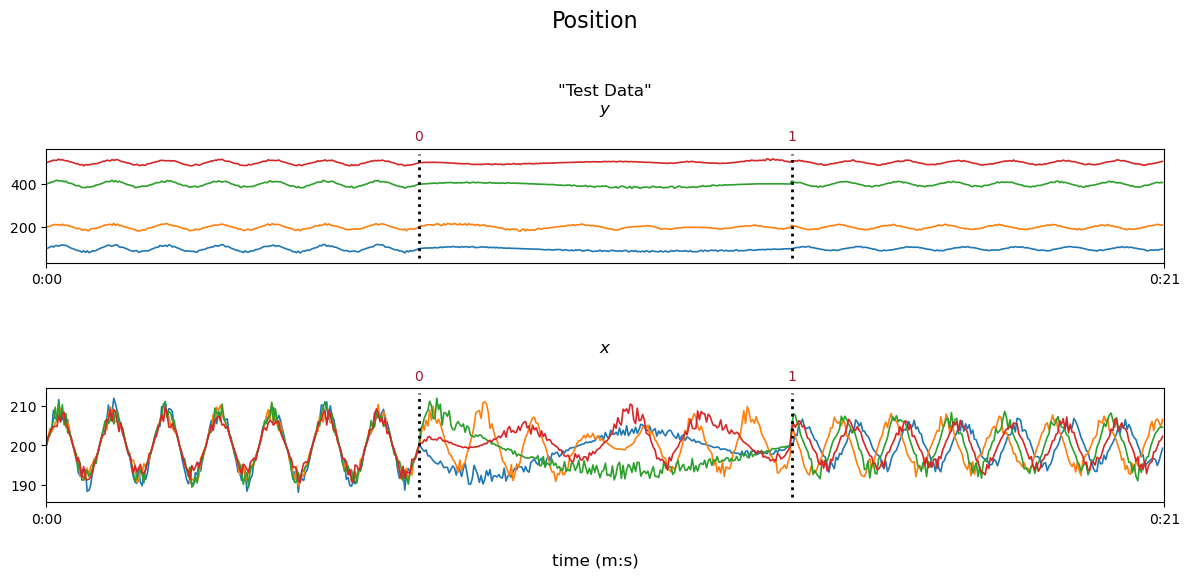

In [41]:
testdata_vars = init_testdatavars()
test_data = testdata(testdata_vars)
position = test_position(test_data,testdata_vars)
sc_ptdata.visualise( position, vscale=1.2, dlattr='1.2'  )

***
### Low-Pass Filter and Speed

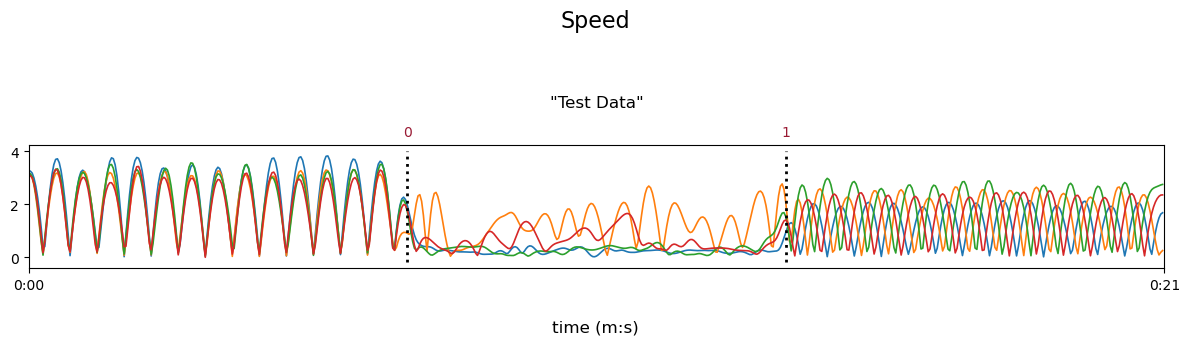

In [25]:
apply_LPF = True # <---

filter_type = 'butter'           # <---
filter_freq_response = 'lowpass' # <---
filter_cutoff_freq = 2           # <--- (Hz)
filter_order = 3                 # <---

if apply_LPF:
    smooth_pos = sc_ptdata.smooth( position, filter_type=filter_type,
                                   freq_response=filter_freq_response,
                                   cutoff_freq=filter_cutoff_freq, order=filter_order )
else: smooth_pos = position
speed = sc_ptdata.apply( smooth_pos, sc_ndarr.tder2D )
sc_ptdata.visualise( speed, vscale=1.4, dlattr='1.2' )

***
### Phase

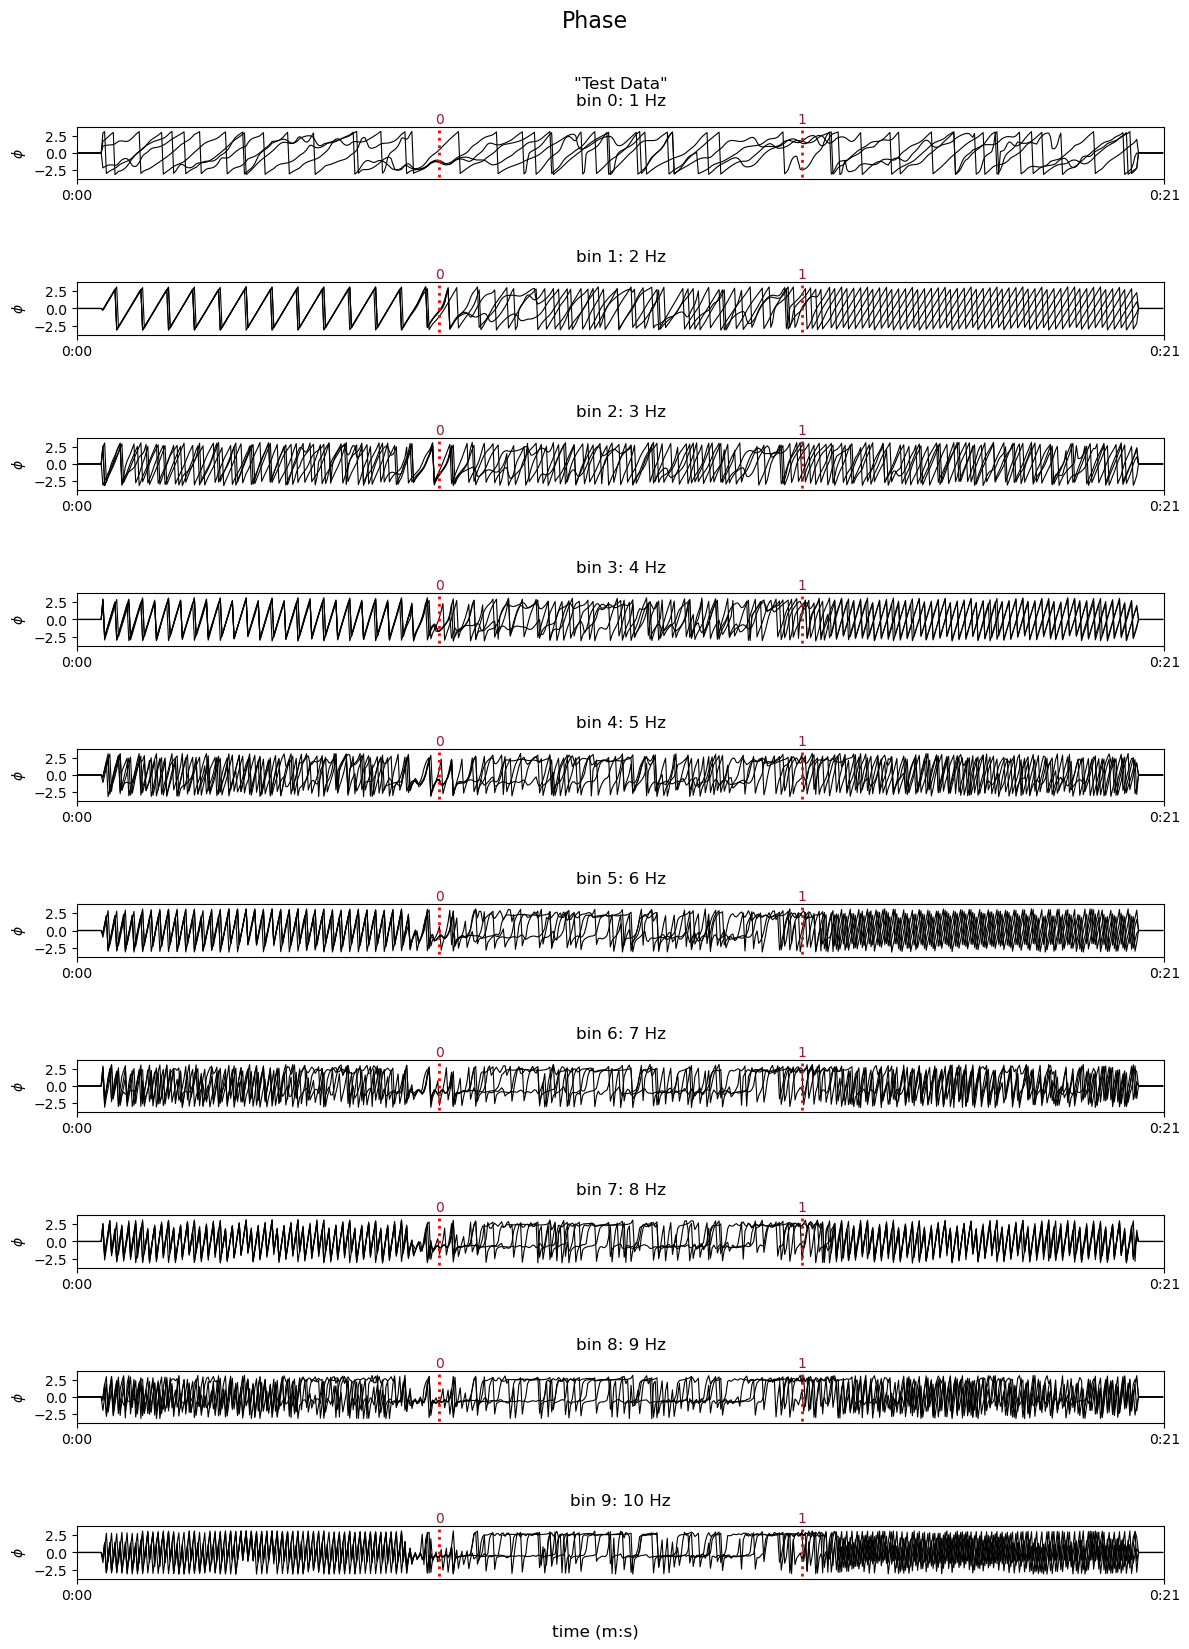

In [26]:
fft_window_s = 1 # <--- FFT window's length (seconds)
sel_freq_bin = slice(0,10) # <--- select frequency bins (int or 'all')

fft_phase = sc_ptdata.fourier( speed, fft_window_s, output='phase' )
if sel_freq_bin == 'all':
    sc_ptdata.visualise( fft_phase, vscale=0.7 )
else:
    fft_phase = sc_ptdata.select(fft_phase,frequency=sel_freq_bin)
    sc_ptdata.visualise( fft_phase, vscale=0.7 )

>
### PLV for each pair:

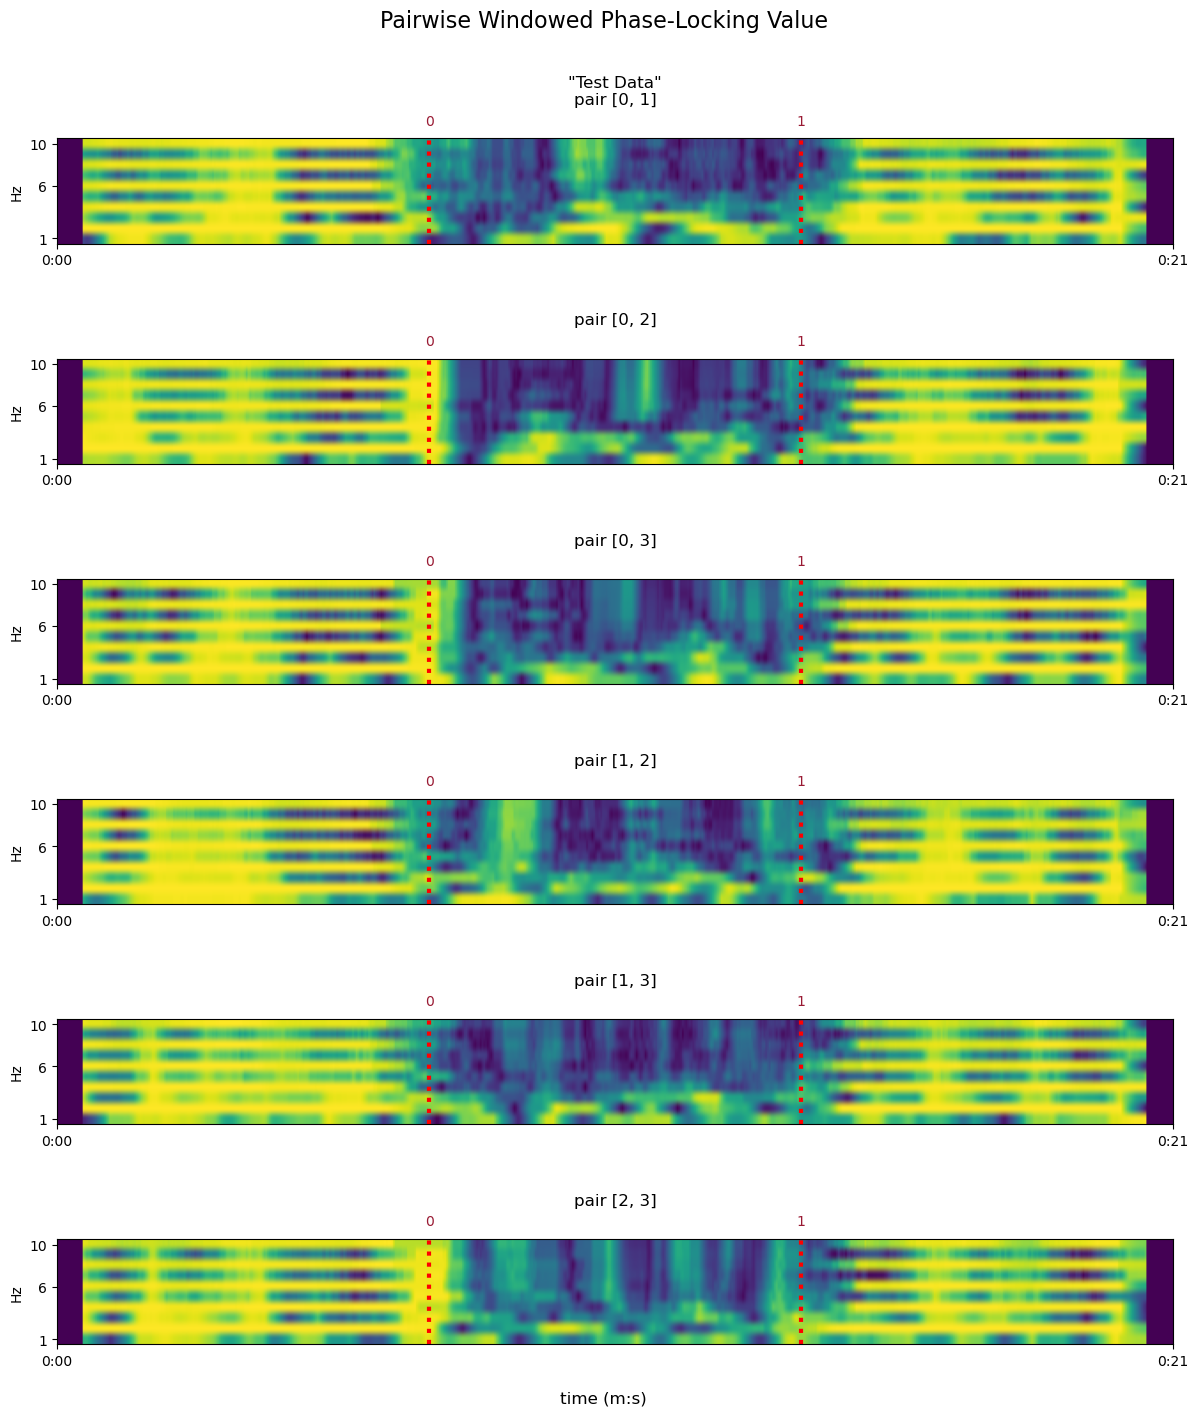

In [27]:
wplv = sc_ptdata.winplv( fft_phase, 1 )
sc_ptdata.visualise( wplv, dlattr='1.2' )

>
### Average PLV for group:

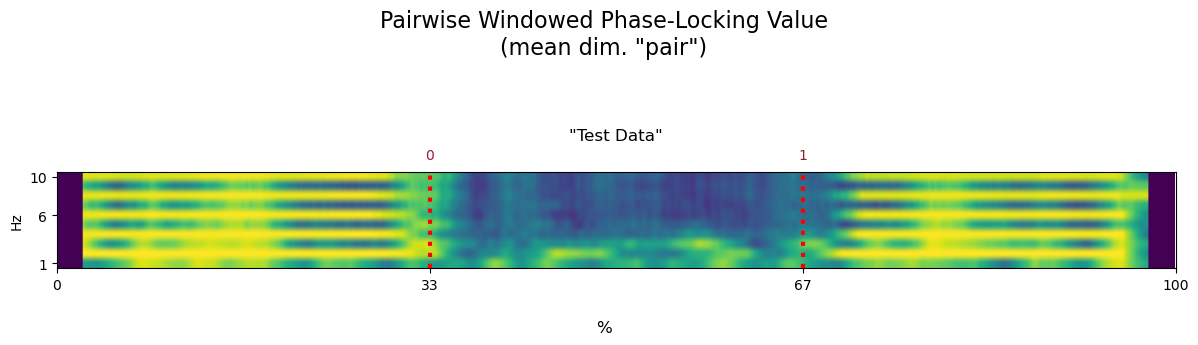

In [28]:
wplv_aggr_pairs = sc_ptdata.aggrax( wplv, axis=0, function='mean' )
sc_ptdata.visualise( wplv_aggr_pairs, vscale=1.4, dlattr='1.2' )

>
### Average band-average PLV for group:

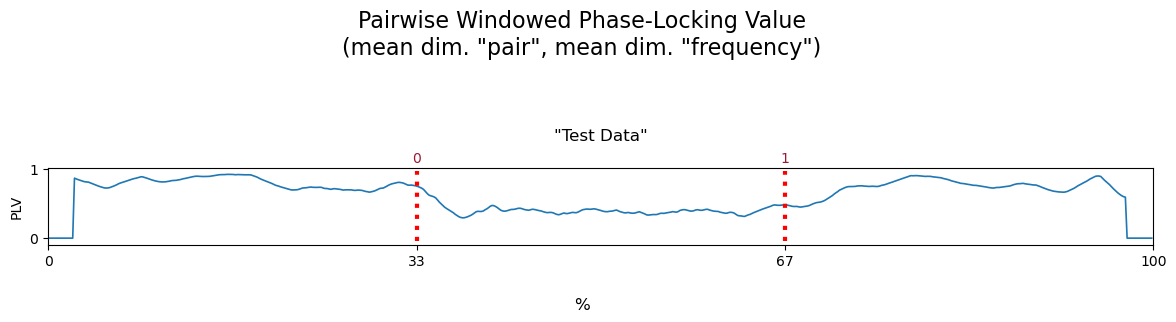

In [32]:
if isinstance(sel_freq_bin,int):
    print('Process does not apply.')
else:
    wplv_aggr_top_sel = sc_ptdata.aggrax( wplv_aggr_pairs, axis=0, function='mean' )
    sc_ptdata.visualise( wplv_aggr_top_sel, vscale=1.3, vistype='line', dlattr='1.2' )